# Final Version 1

<b><i> Identified [Aim](#aim) of the project as, see link to later in document

<div class="alert alert-block alert-info">
<b>Notes:</b><br>Induced Drag: Oswald efficiency number? https://en.wikipedia.org/wiki/Oswald_efficiency_number 
</div>

### External Modules

In [2]:
import numpy as np
import pandas as pd
import ADRpy as ADR
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [3]:
plt.rcParams["figure.figsize"]=15,10 #Set plot size
plt.rcParams.update({'font.size': 16}) #set plot size font
plt.rcParams.update({"axes.grid" : True, "grid.color": "lightgrey"}) #Add grid lines to plot

In [4]:
def Knots(MS):
    return MS / 0.5144

def MS(Knots):
    return Knots * 0.5144

def radian(degree):
    return degree * np.pi/180

### Environment Parameters

In [5]:
g = 9.81        #Gravitational Constant
rho = 1.225

# Wind Speed / Direcion
#     Headwind +ve
#     Cross wind +ve from right
w_vel = 0
w_deg = 0


rway_slope = 0   #Runway slope
mu = 0.03    #Driction Coefficient to Runway Surface



#Possibly ovveride given rho (using ISA altitudes)
temp_c = 15     #Airfield OAT temperacture in celcius
alt_ft = 83     #Airfield (runway) altitude in feet

<div class="alert alert-block alert-info">
Reasonable approximation of g to 9.81 as still very close to this. Density can be resonably approximated to 1.225 as very close to sea level given in relation. only change to the density will come from the temperature change, so use of ADRpy to calculate is ideal, on standard ISA non-offset (research into the offset and why used should be looked at)
</div>

### Aircraft Parameters

#### Airframe

In [6]:
m = 78000        #Mass
#Cl_W = 0     #Cl Wing
#Cl_T = 0     #Cl Tail
S = 122.6        #Wing Area
#S_T = 0      #Tail Area
h_W = 3.38      #Height of wing above the ground

b = 34.1       #Wingspan
#c = 0        #Chord length
c = S/b

In [7]:
#Total Cl for the aircraft
#Cl = Cl_W + (S_T / S) * Cl_T

A = (b**2)/S
e = 0.9
a0 = 2*np.pi
alpha_0L = - radian(2)

def CL(alpha):
    alpha1 = radian(alpha)
    return a0 * ((np.pi*A*e)/(np.pi*A*e + a0)) * (alpha1 - alpha_0L)

#def Cl(alpha):
#    a0 = 2*np.pi
#    alpha0 = radian(2)
#    
#    return a0*(alpha + alpha0/57.3)

In [8]:
CD0 = 0

#### Engine

In [9]:
T = 120.6 * 1e3     #Thrust per engine
n_e = 2   #Number of engines (evenly distributed per wing (i.e. 2 engines = 1 per wing))

### Engine Failure Parameters  (likely not be necessary*)
<i>* Due to running a balanced field model, engine failure is automatically used in calculating this, as such the needed for a failure speed isn't required (this will be covered by the calculated V1 speed). `However, the engine that fails is a parameter that will likely be used and will be an input controlled by the overall Monte Carlo analysis`

In [10]:
V_fail = 0    #Speed at which failure occurs
E_Ident = 0   #Engine Number to fail

<hr style="height:1px;border-width:0;color:black;background-color:black">

### Key Functions

- Lift
- Drag
- Ground Effect
- Friction
- Induced Drag
- phi
<br>

* ODEs for:
    * Velocity
    * Distance travelled

<div class="alert alert-block alert-warning">
Check definition of lift when using total Cl (i.e. when tail is included as well, which S is needed)
</div>
<div class="alert alert-block alert-warning">
Define Drag components seperately (Profile, Induced, Friction etc.) so that ODEs for the different stages can be more easily defined
</div>

In [11]:
def Lift(V,alpha):
    return 0.5 * rho * V**2 * S * CL(alpha)

def Drag(V,alpha):
    return None

def D_i(V,alpha):
    return 0

def D(V,h,alpha):
    return 0.5 * rho * V**2 * S * (CD0 + phi(h) * (CL(alpha)**2)/(np.pi * e * A))

def D_f(V,alpha):
    R = m*g - Lift(V,alpha)
    return mu * R

def phi(h_alt):
    h = h_alt + h_W
    return ((16*h/b)**2)/((1+((16*h/b)**2)))

`Introduction to Flight pg 320` <br>
$\phi = \large\frac{(16 h/b)^{2}}{1+(16 h/b)^{2}}$

In [12]:
#phi = ((16*h_W/b)**2)/((1+((16*h_W/b)**2)))

<hr style="height:1px;border-width:0;color:black;background-color:black">

### Calculating Stall Speed

For stall speed, the lift equals the weight of the aircraft. i.e $L=\frac{1}{2}\rho V^{2}C_{L}S=W=mg$
<br> 
Rearranging for V: $V= \sqrt{\frac{2mg}{\rho C_{L}S}}$

In [13]:
V_s = np.sqrt((2*m*g)/(rho))

### Calculating Rotation Speed

In [14]:
V2 = 1.2 * V_s

<div class="alert alert-block alert-info">
V1 is found by conducting the balanced field investigation for the parameters entered. <br><br> <a id='aim'></a><b> Aim to create a monte carlo analysis of balanced field lengths for a number of different aircraft parameters (should be able to input array for each of the paramters listed under Aircraft Parameters and Environmental Parameters sections above </b>
</div>

<hr style="height:1px;border-width:0;color:black;background-color:black">

In [15]:
Failed_Engine = "N" #N - No failure, #L{0} - Left Failure & how many, #R{0} - Right Failure & how many

In [16]:
#Total engine thrust (per side?)
#T_L = (n_e / 2) * T
#T_R = (n_e / 2) * T

Failed_Engine = Failed_Engine.upper()

if Failed_Engine == "N":
    T_L = T_R = (n_e / 2) * T
    
elif 'L' in Failed_Engine:
    e_p = n_e / 2
    T_L = (e_p - int(Failed_Engine[1:])) * T
    T_R = (n_e / 2) * T
else:
    e_p = n_e / 2
    T_L = (n_e / 2) * T
    T_R = (e_p - int(Failed_Engine[1:])) * T
T_L, T_R

(120600.0, 120600.0)

# AEO (Euler Time-Stepping)

## Accelerate - Stop

### Accelerate

In [17]:
%%time

#Results store
res = []

#Time step (Precision)
t_step = 1e-5

#Initial Conditions
t = 0
V = 0
s = 0

AbortSpeed = 150 #in knots

while Knots(V) < AbortSpeed:
    #Calculate instantaneous accel.
    a = (T_L + T_R - D(V,0,0) - D_f(V,0))/m
    
    V += a * t_step
    s += V*t_step + 0.5*a*t_step**2
    
    res.append([t,V,Knots(V),s])
    
    t += t_step
    
print('Run aborted at {:.6f}'.format(t))

Run aborted at 27.492720
Wall time: 19.3 s


In [18]:
res_t = np.array(res)[:,0]
res_V = np.array(res)[:,2]
res_S = np.array(res)[:,3]

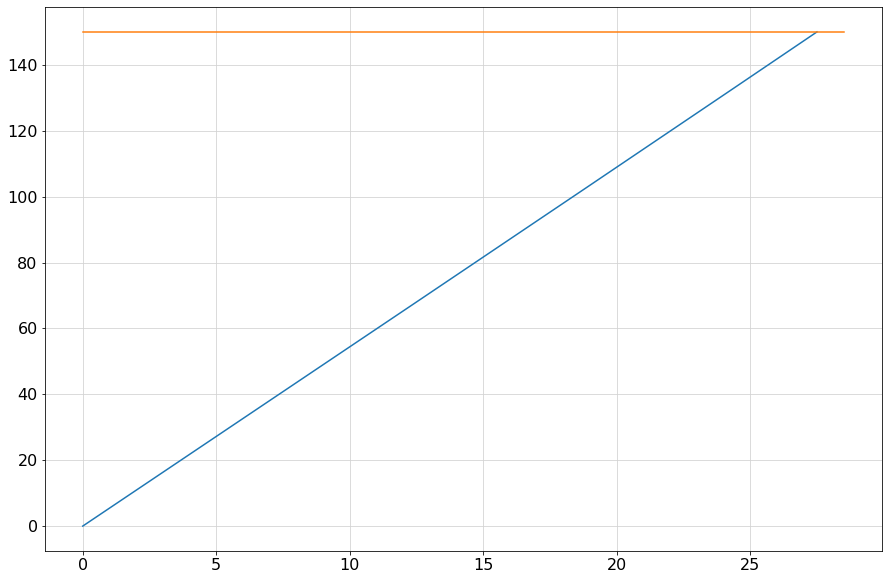

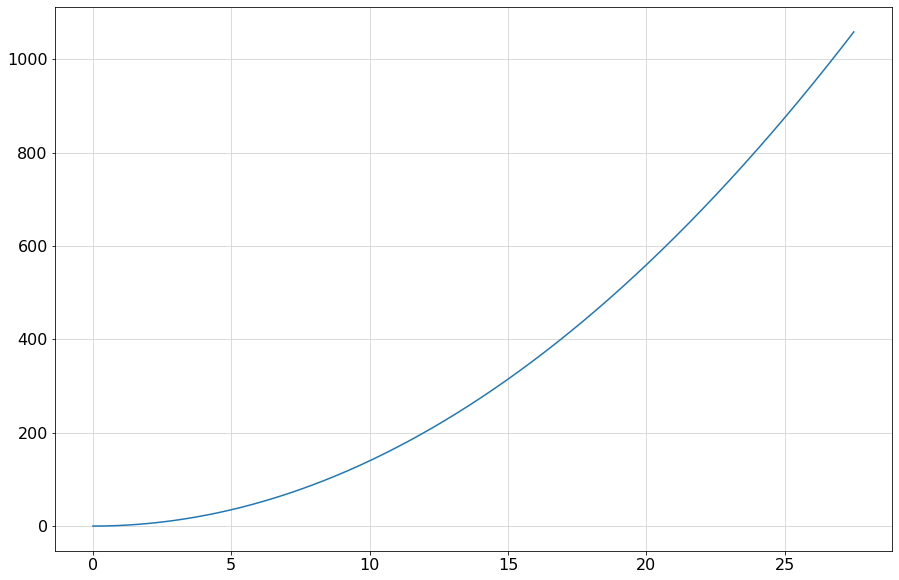

In [19]:
plt.plot(res_t,res_V)
plt.plot([0,res_t[-1]+1],[AbortSpeed,AbortSpeed])
plt.show()
plt.plot(res_t,res_S)
plt.show()

In [20]:
Res_pd = pd.DataFrame(res,columns =['t','V ms-1','V Knots','S'])
Res_pd

,t,V ms-1,V Knots,S
0,0.00000,0.000028,0.000054,4.197012e-10
1,0.00001,0.000056,0.000109,1.119203e-09
2,0.00002,0.000084,0.000163,2.098506e-09
3,0.00003,0.000112,0.000218,3.357609e-09
4,0.00004,0.000140,0.000272,4.896513e-09
5,0.00005,0.000168,0.000326,6.715218e-09
6,0.00006,0.000196,0.000381,8.813724e-09
7,0.00007,0.000224,0.000435,1.119203e-08
8,0.00008,0.000252,0.000490,1.385014e-08
9,0.00009,0.000280,0.000544,1.678805e-08


### Stopping

In [21]:
%%time 

while Knots(V) > 0:
    #Calculate instantaneous accel.
    a = -0.5* 9.81
        
    V += a * t_step
    s += V*t_step + 0.5*a*t_step**2
    
    res.append([t,V,Knots(V),s])
    
    t += t_step

Wall time: 4.34 s


In [22]:
res_t = np.array(res)[:,0]
res_V = np.array(res)[:,2]
res_S = np.array(res)[:,3]

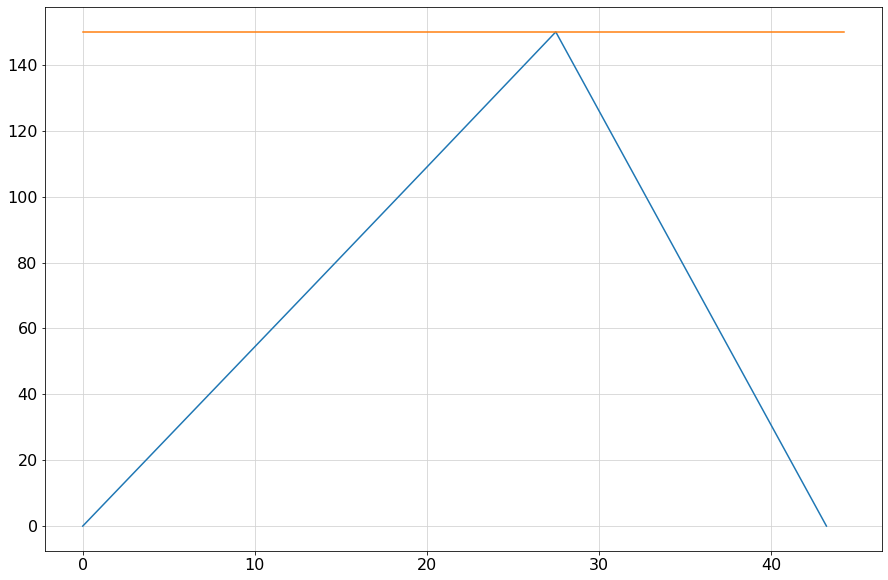

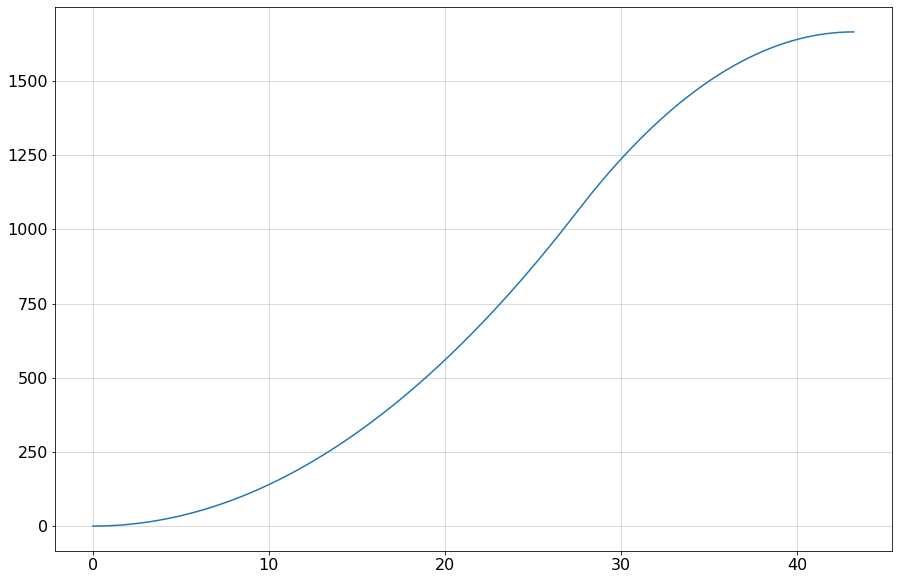

In [23]:
plt.plot(res_t,res_V)
plt.plot([0,res_t[-1]+1],[AbortSpeed,AbortSpeed])
plt.show()
plt.plot(res_t,res_S)
plt.show()

In [24]:
Res_pd = pd.DataFrame(res,columns =['t','V ms-1','V Knots','S'])
Res_pd

,t,V ms-1,V Knots,S
0,0.00000,0.000028,0.000054,4.197012e-10
1,0.00001,0.000056,0.000109,1.119203e-09
2,0.00002,0.000084,0.000163,2.098506e-09
3,0.00003,0.000112,0.000218,3.357609e-09
4,0.00004,0.000140,0.000272,4.896513e-09
5,0.00005,0.000168,0.000326,6.715218e-09
6,0.00006,0.000196,0.000381,8.813724e-09
7,0.00007,0.000224,0.000435,1.119203e-08
8,0.00008,0.000252,0.000490,1.385014e-08
9,0.00009,0.000280,0.000544,1.678805e-08


In [25]:
print('Run stopped at {:.6f}'.format(res_t[-1]))
print('Run length     {:.6f}'.format(res_S[-1]))

Run stopped at 43.223610
Run length     1665.949036


## Take-off to 35ft

Notes:
 - For engine failure, thrust is dependent on the velocity, cut engine at speed just after V1

### Ground Run

In [26]:
%%time 

#Results store
res = []

#Time step (Precision)
t_step = 1e-5

#Initial Conditions
t = 0
V = 0
s = 0

Vr = 170 #in knots

while Knots(V) < Vr:
    #Calculate instantaneous accel.
    dVdt = (T_L + T_R - D(V,0,0) - D_f(V,0))/m
    
    V += dVdt * t_step
    s += V*t_step + 0.5*dVdt*t_step**2
    
    res.append([t,V,Knots(V),s])
    
    t += t_step


Wall time: 23.3 s


In [27]:
res_t = np.array(res)[:,0]
res_V = np.array(res)[:,2]
res_S = np.array(res)[:,3]

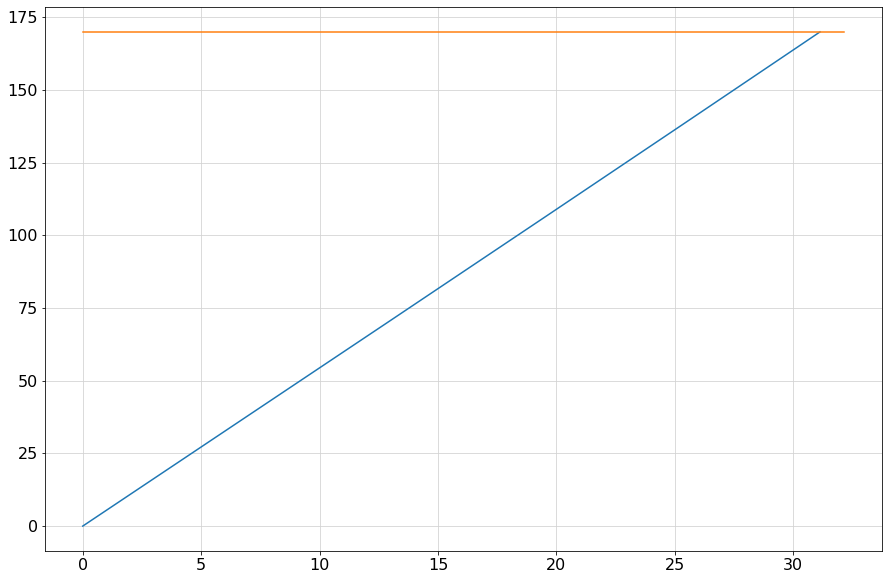

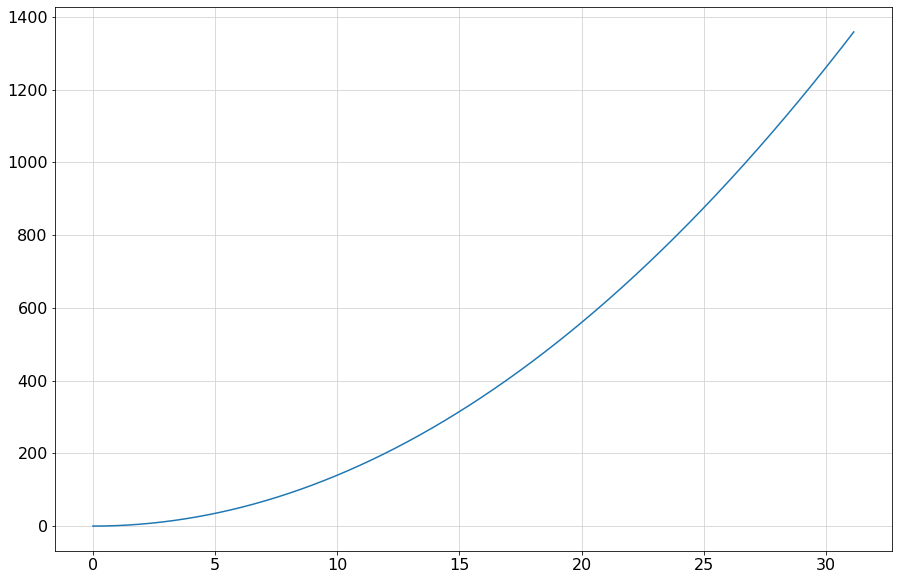

In [28]:
plt.plot(res_t,res_V)
plt.plot([0,res_t[-1]+1],[Vr,Vr])
plt.show()
plt.plot(res_t,res_S)
plt.show()

### Transition / Rotate

Remember:
 - Friction still present in roatation
 - Change in AoA
 - Track Angle remains 0
 

In [29]:
rotate_rate = 5

#V_LOF - Lift=Weight
#Defining Lift-Off termination function to end solution when aircraft leaves the ground
def LOF(t,y):
    L = Lift(y[0],y[2])*np.cos(np.radians(y[2]))    
    W = m * g
    return L - W
LOF.terminal = True

#Defining the equations of motion for the rotation phase
def rotate(t,y):
    Vx = y[0]
    X = y[1]
    Alpha = y[2]
    
    dVxdt = (1/m) * ((T_L + T_R)*np.cos(np.radians(Alpha)) - D(V,0,Alpha) - D_f(V,Alpha))
    dAlphadt = rotate_rate
    dXdt = Vx

    return np.array([dVxdt,dXdt,dAlphadt])

In [30]:
# initial conditions - taken from output of ground run
x0 = res_S[-1] 
vx0 = MS(res_V[-1]) 
alpha0 = 0
y0 = np.array([vx0,x0,alpha0])

sol_rotate = solve_ivp(rotate,[0,20],y0,rtol=1e-9,max_step = 1e-3,events=[LOF])

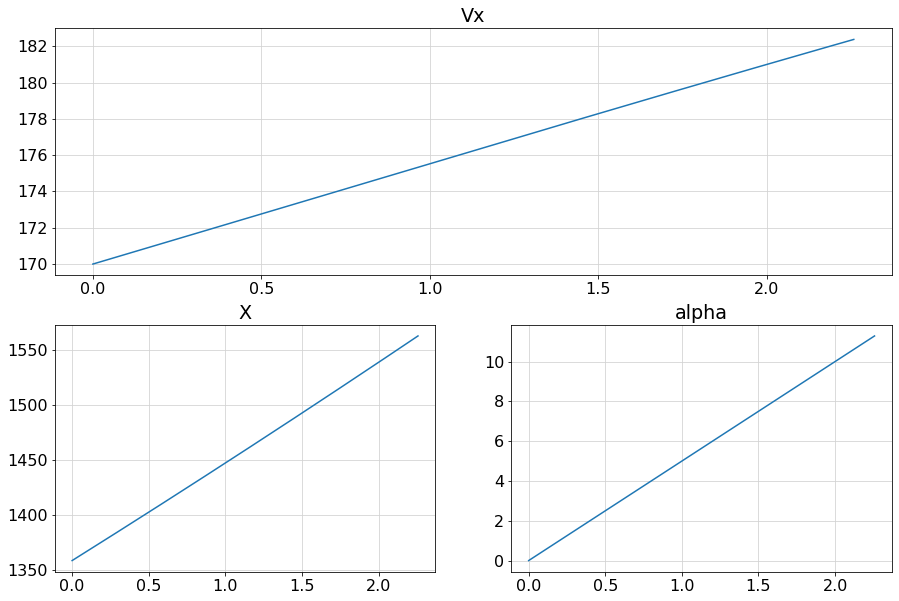

In [31]:
# plt.plot(sol_rotate.t,sol_rotate.y[0]) # vx
# plt.show()
# plt.plot(sol_rotate.t,sol_rotate.y[1]) # x
# plt.show()
# plt.plot(sol_rotate.t,sol_rotate.y[2]) # alpha
# plt.show()
# #plt.plot(sol_rotate.t,sol_rotate.y[2] / (np.pi/180))
# #plt.show()

ax0 = plt.subplot(211)
ax1 = plt.subplot(223)
ax2 = plt.subplot(224)

ax0.set_title('Vx')
ax0.plot(sol_rotate.t,Knots(sol_rotate.y[0]))
ax1.set_title('X')
ax1.plot(sol_rotate.t,sol_rotate.y[1])
ax2.set_title('alpha')
ax2.plot(sol_rotate.t,sol_rotate.y[2])

### Climb Out to 35ft

In [32]:
Vw = 0
alpha = theta = sol_rotate.y[2][-1]
alpha

11.287830166258395

In [33]:
%%time

def ScreenHeight(t,y):
    return y[3] - 10.7
ScreenHeight.terminal = True

def f(t,y):
    Vx = y[0]  
    Vz = y[1]
    X = y[2]
    H = y[3]
    
    V = np.sqrt(Vx**2 + Vz**2)
    dVxdt = (1/m) * ((T_L + T_R)*np.cos(np.radians(theta)) - D(V,0,theta)*np.cos(np.radians(theta)) - Lift(V,theta)*np.sin(np.radians(theta)))
    dVzdt = (1/m) * ((T_L + T_R)*np.sin(np.radians(theta)) + Lift(V,theta)*np.cos(np.radians(theta)) - m*g - D(V,0,theta)*np.sin(np.radians(theta)))
    dXdt = Vx
    dHdt = Vz
    
    return np.array([dVxdt, dVzdt, dXdt, dHdt]) # return array

# initial conditions from rotation
x0 = sol_rotate.y[1][-1]
vx0 = sol_rotate.y[0][-1]
vz0 = 0
h0 = 0
y0 = np.array([vx0,vz0,x0,h0])

sol_LOF = solve_ivp(f,[0,40],y0,rtol=1e-9,max_step = 1e-3,events=[ScreenHeight])

Wall time: 4.37 s


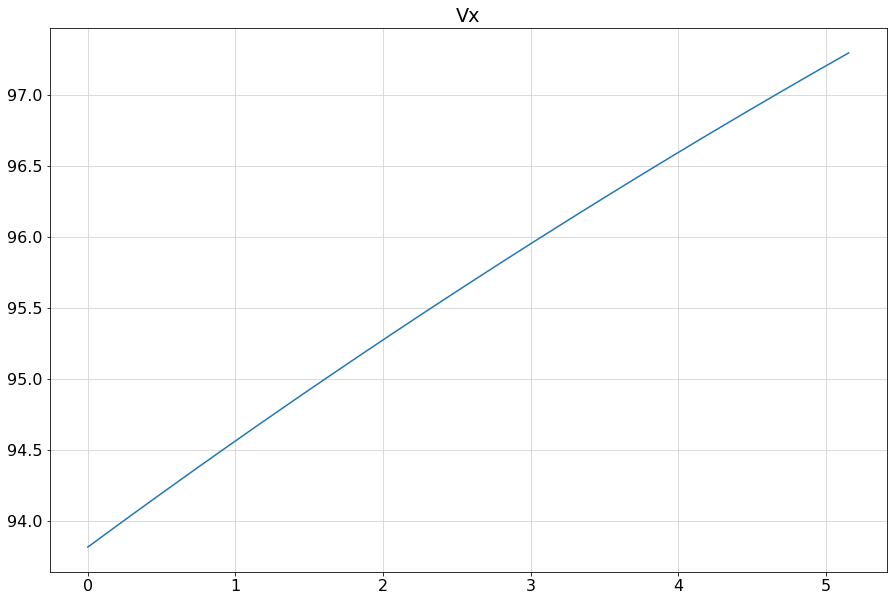

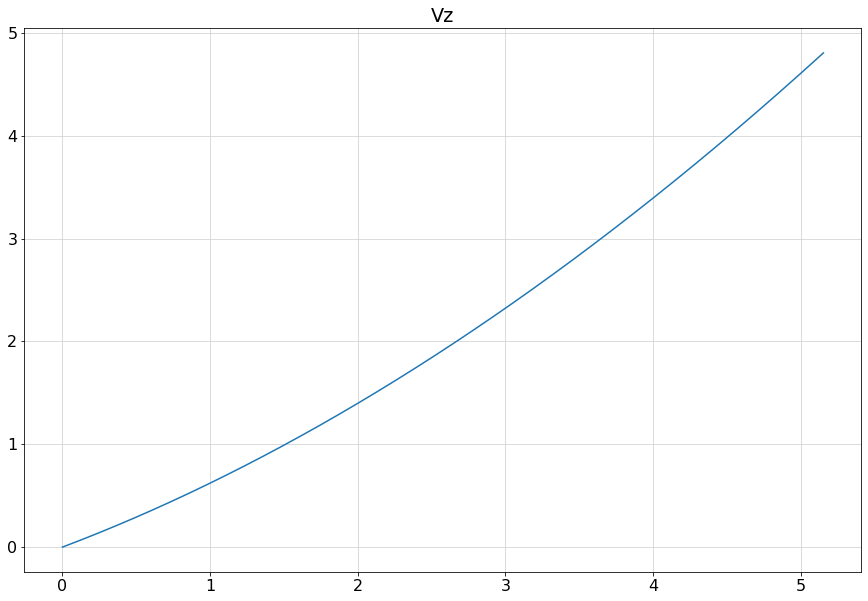

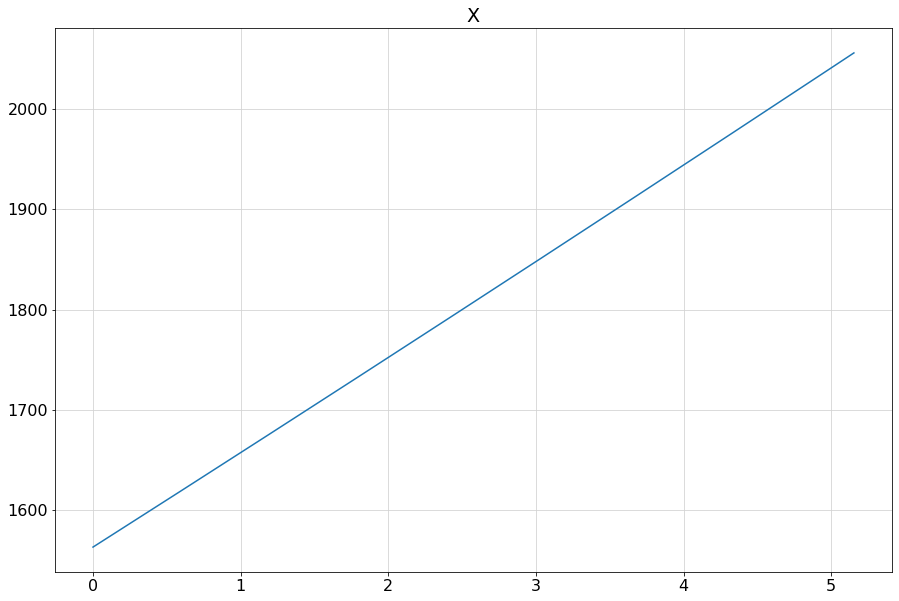

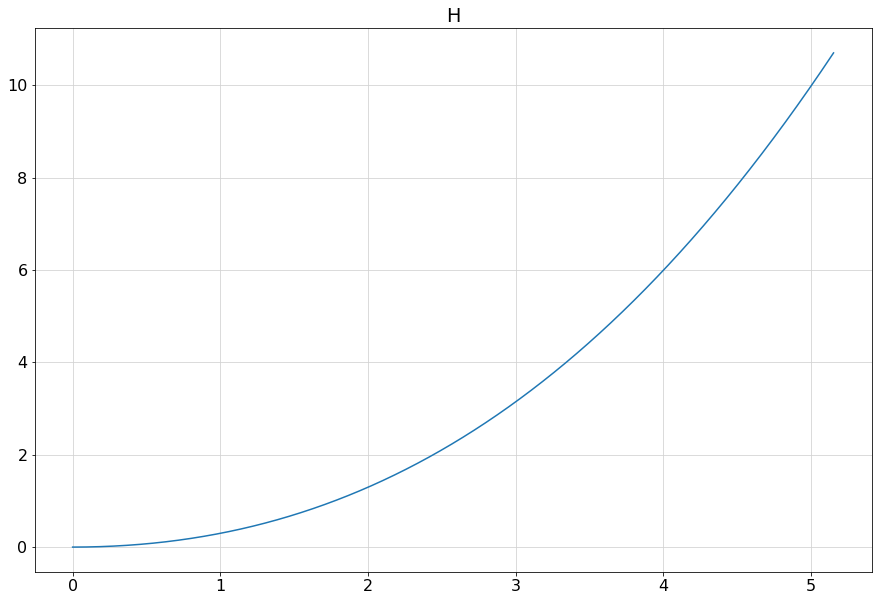

In [34]:
plt.title('Vx')
plt.plot(sol_LOF.t,sol_LOF.y[0])
plt.show()
plt.title('Vz')
plt.plot(sol_LOF.t,sol_LOF.y[1])
plt.show()
plt.title('X')
plt.plot(sol_LOF.t,sol_LOF.y[2])
plt.show()
plt.title('H')
plt.plot(sol_LOF.t,sol_LOF.y[3])
plt.show()

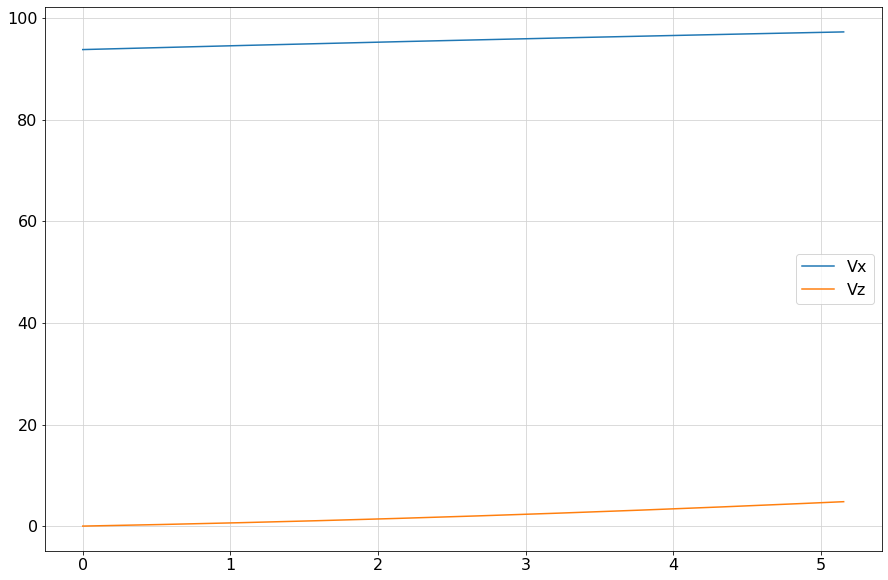

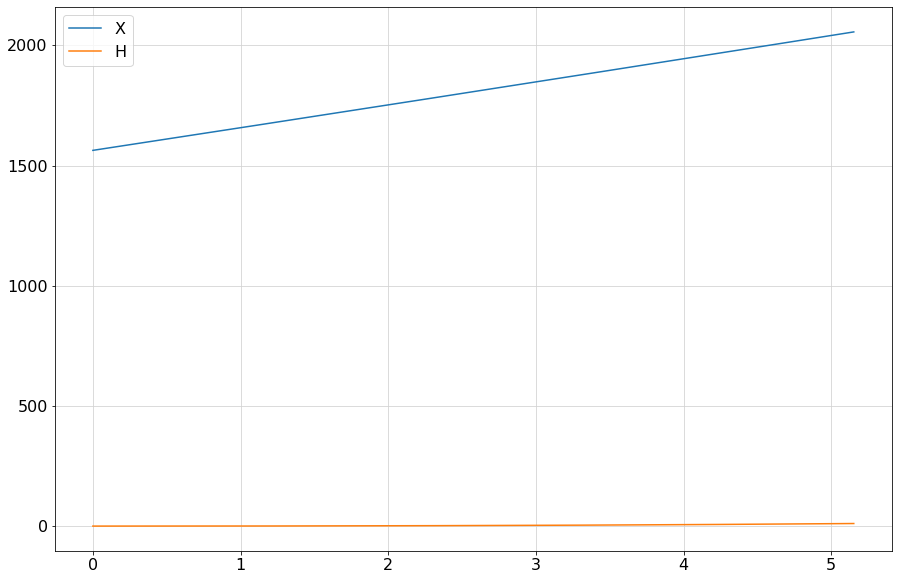

In [35]:
plt.plot(sol_LOF.t,sol_LOF.y[0],label = 'Vx')
plt.plot(sol_LOF.t,sol_LOF.y[1],label = 'Vz')
plt.legend()
plt.show()
plt.plot(sol_LOF.t,sol_LOF.y[2],label = 'X')
plt.plot(sol_LOF.t,sol_LOF.y[3],label = 'H')
plt.legend()
plt.show()

In [43]:
sol_LOF.y[2][-1]

2055.98825672594

In [36]:
Knots(sol_LOF.y[0][-1])

189.1423611025593

In [37]:
Knots(sol_LOF.y[1][-1])

9.341532756376864

In [38]:
np.sqrt((Knots(sol_LOF.y[0][-1]))**2+(Knots(sol_LOF.y[1][-1]))**2)

189.3729046027689

In [41]:
at = np.arctan(sol_LOF.y[1][-1]/sol_LOF.y[0][-1])

In [42]:
np.degrees(at)

2.8274779089339304

pitch angle / track angle / speed / speed at screen height